# TOY_TRAIN EDA

In [39]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime


pd.set_option('max_colwidth', 140)

In [2]:
!head -1 toy_train.json

{"reviewerID": "AVITXW9Q9COJL", "asin": "0002247399", "reviewerName": "Carol Brennan", "helpful": [0, 5], "reviewText": "My husband has really loved this series and I have heard the same comments from many others who have also read this series.", "overall": 5.0, "summary": "A Dance With Dragons", "unixReviewTime": 1389398400, "reviewTime": "01 11, 2014"}


In [3]:
# load up the data
df = pd.read_json('toy_train.json',lines=True)

## FIRST MAKE HELPFULNESS WORKABLE

In [7]:
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)

In [8]:
df['unhelpful_votes'] = df.apply(lambda x: x.helpful[1],axis=1)

In [9]:
# Augment with helpfulness score (ratio of helpful votes to total votes)
df['Hscore'] = df.apply(lambda x: x.helpful_votes/(x.helpful_votes + x.unhelpful_votes),axis=1)

## (UN)HELPFUL EXAMPLE
Review 0 below has 5 ppl saying the review is not helpful, and I would agree with them! This could be a good example of the start of our inquiry (what NOT to show a shopper), because there is really no information in this review.

In [11]:
df.head(1)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,char_count,helpful_votes,unhelpful_votes,Hscore
0,0002247399,"[0, 5]",5,My husband has really loved this series and I have heard the same comments from many others who have also read this series.,2014-01-11,AVITXW9Q9COJL,Carol Brennan,A Dance With Dragons,1389398400,123,0,5,0.0


## CHECK OUT RATING DISTRIBUTION

In [12]:
df.overall.value_counts()
# We have very few low-rated books reviews

5    202
4     79
3     44
2     31
1     18
Name: overall, dtype: int64

Text(0.5,0,'Rating of review')

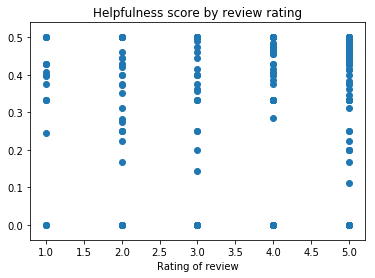

In [59]:
plt.scatter(x=df.overall,y=df.Hscore)
plt.title("Helpfulness score by review rating")
plt.xlabel("Rating of review")

## MAKE TIMEFRAME WORKABLE

In [4]:
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)

In [33]:
df.sort_values(by=['reviewTime'],inplace=True,ascending=True)

In [36]:
df.reviewTime.head()

65    1998-01-04
34    1999-03-18
33    1999-08-20
289   2000-05-06
139   2000-05-15
Name: reviewTime, dtype: datetime64[ns]

In [42]:
df.reviewTime.tail()

257   2014-06-23
138   2014-06-24
201   2014-06-27
331   2014-06-27
354   2014-07-01
Name: reviewTime, dtype: datetime64[ns]

In [50]:
last_rvw = df.reviewTime.max()
df['review_age'] = df.apply(lambda x: (last_rvw - x.reviewTime).days,axis = 1)

## HOW DOES HELPFULNESS CORRELATE WITH YEAR/AGE?
More reviews are written over the time period as time progresses in this dataset

(array([  3.,   9.,  12.,   7.,  25.,  27.,  33.,  37.,  74., 147.]),
 array([729393. , 729995.2, 730597.4, 731199.6, 731801.8, 732404. ,
        733006.2, 733608.4, 734210.6, 734812.8, 735415. ]),
 <a list of 10 Patch objects>)

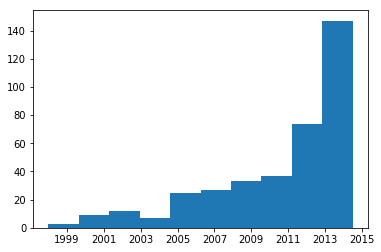

In [15]:
plt.hist(df.reviewTime)

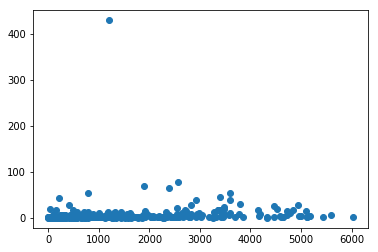

In [60]:
# Check out any relationship between getting helpful votes and age of review
plt.scatter(x=df.review_age,y=df.helpful_votes)


## NOTE ODD DISTRIBUTION OF HELPFULNESS SCORE RATIO

In [61]:
df.Hscore.describe()
# it is interesting here that our sample maximum Hscore (helpfulness ratio) is 50%

count    374.000000
mean       0.391335
std        0.165860
min        0.000000
25%        0.333333
50%        0.485667
75%        0.500000
max        0.500000
Name: Hscore, dtype: float64

Above max of 50% and below null finding still seems odd to Jen: NO review EVER has more helpful than unhelpful votes. This may explain why Amazon rm'd the unhelpful button (perhaps too many ppl just always voted unhelpful?)

# TODO look at this on the next order of magnitude sample

If we feel the unhelpful votes are being "gamed", we may want to declare reviews above a threshold of helpful votes (or above a helpful vote-count per year) to be helpful for our study purposes.

In [17]:
df[df.unhelpful_votes < df.helpful_votes]


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,char_count,helpful_votes,unhelpful_votes,Hscore


## INVESTIGATE REVIEW LENGTH

In [5]:
df['char_count'] = df.apply(lambda x: len(x.reviewText),axis=1)
# df['word_count'] = df.apply(lambda x: len([word for word in x.reviewText.split()]),axis=1)
# I'm not sure this buys us anything beyond character count

## HELPFULNESS SCORE BY LENGTH
Few reviews exceed 1000 characters, but certainly these longer reviews do get noticed/marked helpful.

Text(0.5,1,'How helpful_vote count varies with Length of Review')

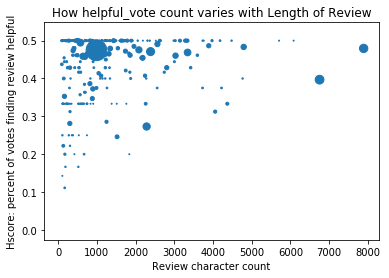

In [18]:
plt.scatter(y=df.Hscore,x=df.char_count,s=df.helpful_votes)
plt.xlabel('Review character count')
plt.ylabel('Hscore: percent of votes finding review helpful')
plt.title ('How helpful_vote count varies with Length of Review')

## TOLERANCE FOR REVIEW LENGTH
It might be interesting to personalize reviews based on a shopper's TOLERANCE FOR LENGTH.
In other words, only display concise reviews vs. I prefer longer, more detailed reviews
To personalize, in the search query generating the ranked reviews, we could ask for an interest AND a preferred length, like 1 sentence, 1 paragraph, or multiple paragraphs.


## FOUND A SAMPLE REVIEW

In [19]:
df[df.helpful_votes > 400]

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,char_count,helpful_votes,unhelpful_votes,Hscore
287,0143120530,"[429, 475]",3,"After reading the first chapter of this book online, I went out and picked up a copy and read it. I was under the impression from readi...",2011-03-17,ANTX2LDFI5A51,Tony R. Vaughan,"A good read, but ...",1300320000,988,429,475,0.474558


YES! I found the above review online here:
[A good read, but](https://www.amazon.com/gp/customer-reviews/R15T443X49LY3C/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=0143120530)

In 2019, it now has 543 helpful votes (it was written in 2011 and our data snapshot shows 429 helpful votes at snapshot time, vs 475 unhelpful votes).


# APPENDIX

In [ ]:
# verified we filtered the unlabeled reviews out
df[(df.helpful_votes == 0) & (df.unhelpful_votes == 0)]


## MOSTLY UNIQUE BOOKS

In [13]:
df.asin.value_counts().value_counts()
# In this toy-size sample of 373, just one book is represented by 2 reviews 

1    372
2      1
Name: asin, dtype: int64

In [ ]:
# Appendix of less helpful code
# plt.hist(df.helpful_votes)
# plt.scatter(y=df.helpful_votes,x=df.char_count,s=np.log2(df.Hscore + .0001)**2)
# plt.xlabel('Review character count')
# plt.ylabel('Count of helpful votes')
# plt.title ('How Helpfulness Score Hscore varies with Length of Review')
# plt.scatter(y=df.helpful_votes,x=df.word_count)